**03_modelling**


- Tested a range of hyperparameters to check which range would be used for hyperparameter search
- used hyperopt (Baysian optimization) to choose best hyperparameters
- trained final model on merged validation + training dataset.
- did permutation testing on the model by swapping outcome variables

used this container: 
ml:1.0

In [1]:
import logging
import pathlib
import os
import requests
import tempfile


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as ss
from itertools import compress

from sklearn import metrics
import matplotlib.pyplot as plt

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, rand

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, permutation_test_score

import pickle

from helper_functions import *

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


# Define functions + Read in data

In [2]:
def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        # important int, as it takes integers only
        'max_depth': int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'min_child_weight': params['min_child_weight'],
        'reg_alpha': params['reg_alpha'],
        'colsample_bytree': params['colsample_bytree'],
        'subsample': params['subsample'],   
        'random_state': 1000,
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    gbm = xgb.XGBClassifier(**params_dict)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    # train with cv
    score_result = cross_val_score(gbm, train[:,1:], train[:,0],
                            scoring='roc_auc', cv=kfold, n_jobs=4)
    
    #score = score_result.mean()/score_result.std()
    score = score_result.mean()

    # to minimize, we negate the score
    return -score

def hyperparamtuning(train, validation, file_name_base, base_dir, output_suffix):
    
    # search space explanation https://hyperopt.github.io/hyperopt/getting-started/search_spaces/
    # define param grid, hp.choice doesn't really work, there's a bug where it does not really choose the ranges that are given, need to use quniform and then convert to int
    param_grid = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.025), np.log(0.1)),
    'n_estimators': hp.quniform('n_estimators', 50, 150, 50),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 0.8, 0.01),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),   
    'min_child_weight': hp.quniform('min_child_weight', 1, 15, 1),
    'reg_alpha' : hp.quniform('reg_alpha', 1,15,1),
    'subsample': hp.uniform('subsample', 0.50, 0.90),   
    }
    
    # fmin performs the minimization
    # rand.suggest samples the parameters at random
    # i.e., performs the random search

    random_search = fmin(
        fn=objective,
        space=param_grid,
        max_evals=50,
        rstate=np.random.default_rng(42),
        algo=tpe.suggest,  
    )
    print('best hyperparameters', random_search)
    
    params = {'colsample_bytree': random_search['colsample_bytree'],
     'learning_rate': random_search['learning_rate'],
     'n_estimators': int(random_search['n_estimators'].round()),        
     'max_depth': int(random_search['max_depth'].round()),
     'min_child_weight': int(random_search['min_child_weight']),
     'reg_alpha': random_search['reg_alpha'],
     'subsample': random_search['subsample']}

    model = XGBClassifier(**params)

    # define the datasets to evaluate each iteration
    evalset = [(train[:,1:],train[:,0]), (validation[:,1:],validation[:,0])]
    # fit the model
    model.fit(train[:,1:],train[:,0], early_stopping_rounds=10, eval_metric='logloss', eval_set=evalset, verbose=False)

    loglosscurve(model, validation, base_dir, output_suffix, file_name_base, save_fig = True)
    
    # get the number of estimators of this model and fit new model on entire dataset
    model.get_xgb_params()
    n_estimators_best = model.best_ntree_limit
    params['n_estimators'] = n_estimators_best

    model = XGBClassifier(**params)

    # combine validation and training for final model
    merged = np.concatenate((train, validation), axis=0)
    
    # fit the model
    model.fit(merged[:,1:],merged[:,0],verbose=False)

    permutscoring(model, merged, base_dir, output_suffix, file_name_base, save_fig = True)
    
    # save the model to disk
    filename = f'{base_dir}{suffix}{file_name_base}'
    
    # Save model into JSON format - this is the modern way to do it!
    model.save_model(f'{filename}/model.json')
    

In [3]:
# paths
base_dir = '/home/jovyan/work/Goldfinch/ML_paper/'
output_suffix = 'output_files/training_output/'
suffix = 'raw_data/intermediate_files/'

## Exploring potential ranges of hyperparameters

In [4]:
# Read to explore hyperparambeters
executionid = 1

df_model = pd.read_csv(f'{base_dir}raw_data/reprocessed_model_log.csv')
file_name_base = str(df_model[df_model['ExecutionID'] == executionid][['aggregation_time','gap']].values[0][0]) + '_years_' + str(df_model[df_model['ExecutionID'] == executionid][['aggregation_time','gap']].values[0][1])    

train = pd.read_csv(f"{base_dir}{suffix}{file_name_base}/train.csv", header = None).to_numpy()
validation = pd.read_csv(f"{base_dir}{suffix}{file_name_base}/validation.csv", header = None).to_numpy()

0.001
Accuracy: 0.708


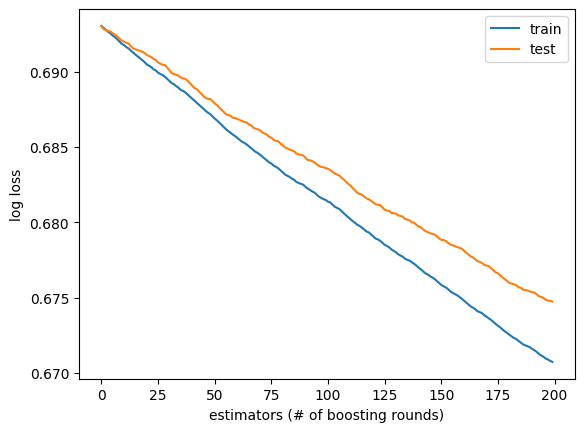

0.025
Accuracy: 0.685


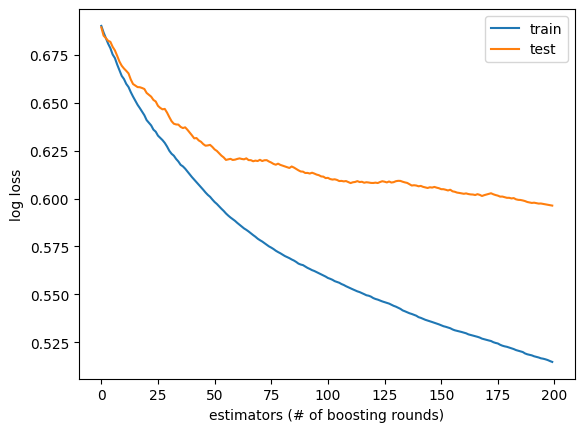

0.05
Accuracy: 0.697


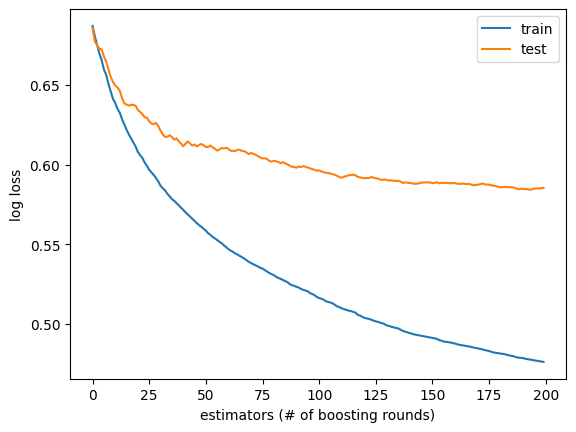

0.3
Accuracy: 0.697


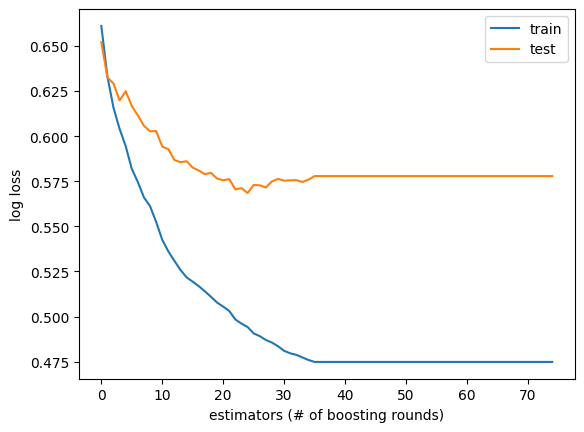

0.5
Accuracy: 0.674


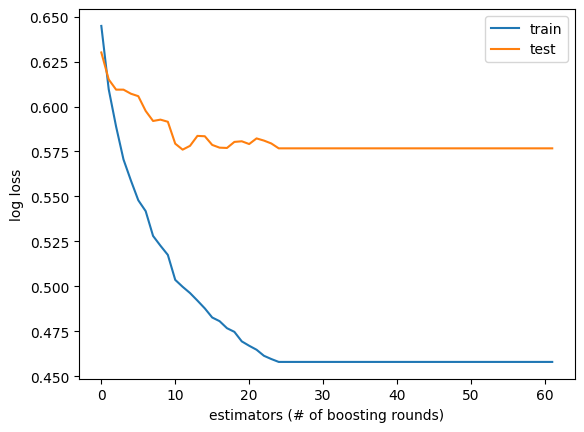

In [5]:
ranges = [0.001, 0.025, 0.05, 0.3, 0.5]
parameter = 'learning_rate'

testhyperparameterranges(train, validation, parameter, ranges)

0.1
Accuracy: 0.697


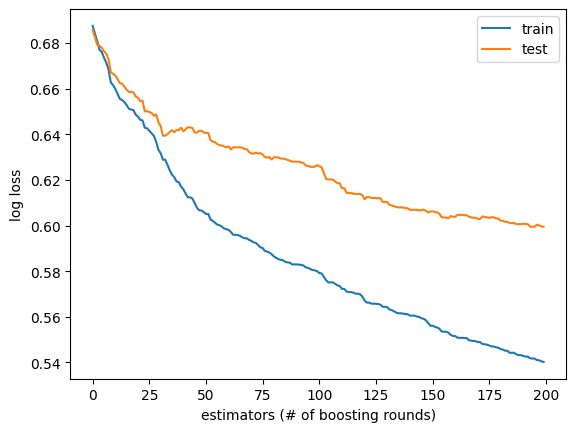

0.25
Accuracy: 0.685


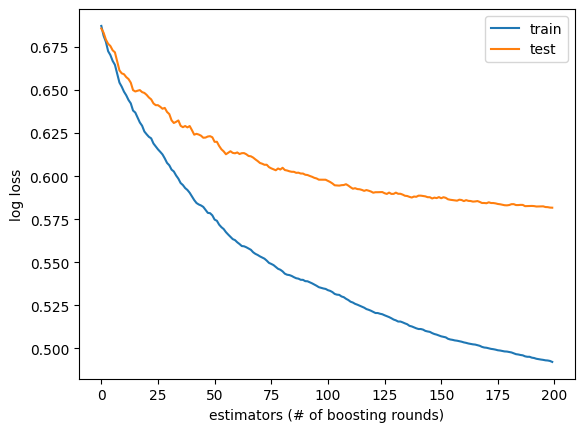

0.5
Accuracy: 0.697


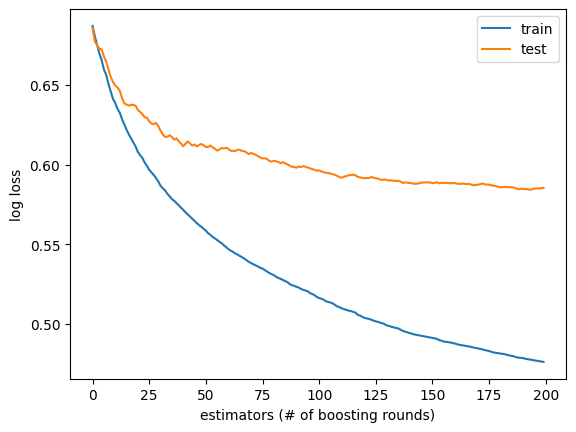

0.7
Accuracy: 0.674


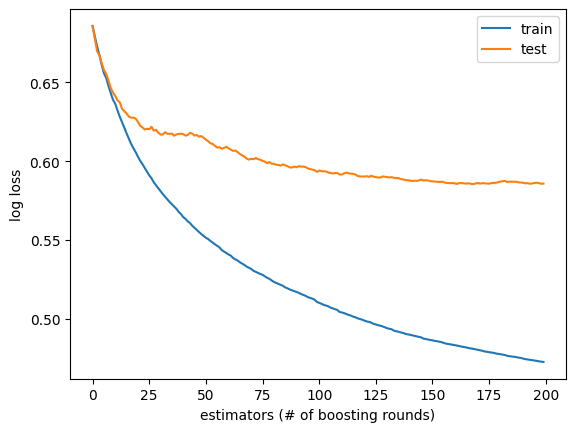

0.95
Accuracy: 0.652


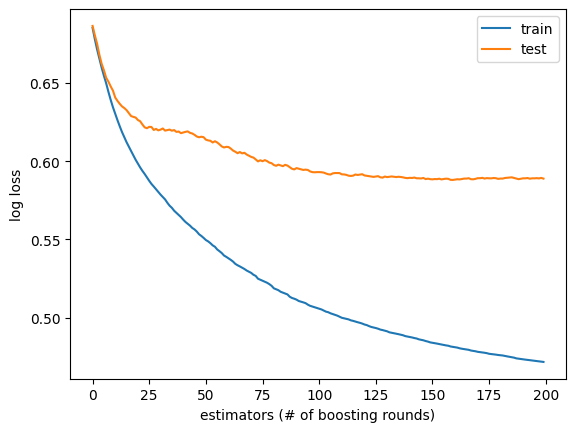

In [6]:
ranges = [0.1, 0.25, 0.5, 0.7, 0.95]
parameter = 'colsample_bytree'

testhyperparameterranges(train, validation, parameter, ranges)

3
Accuracy: 0.697


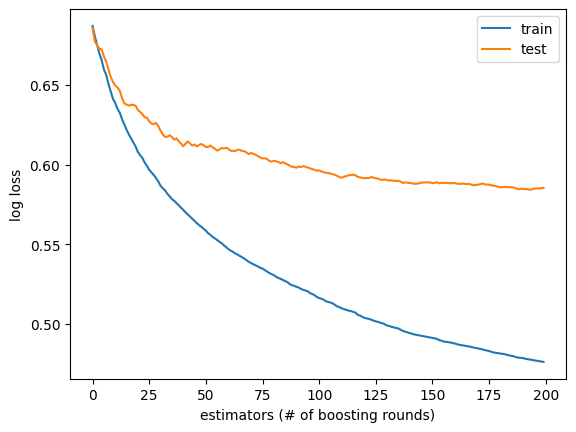

6
Accuracy: 0.674


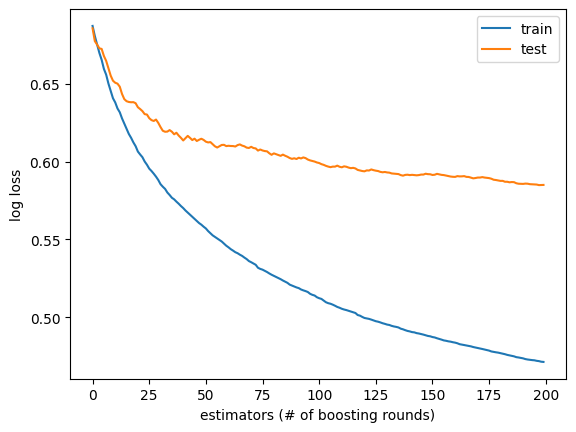

12
Accuracy: 0.674


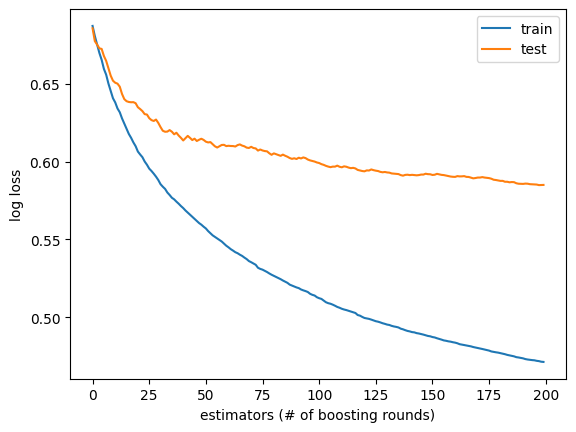

18
Accuracy: 0.674


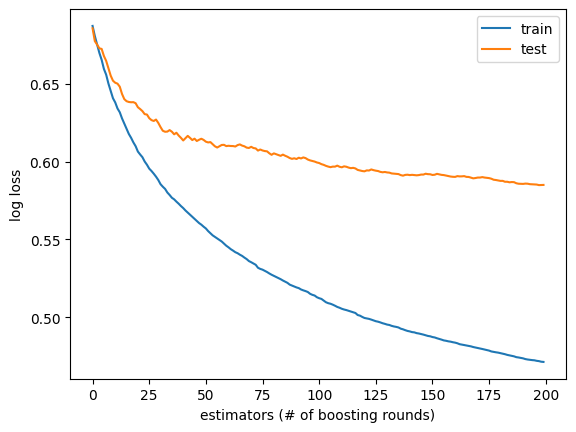

In [7]:
ranges = [3, 6, 12, 18]
parameter = 'max_depth'

testhyperparameterranges(train, validation, parameter, ranges)

1
Accuracy: 0.663


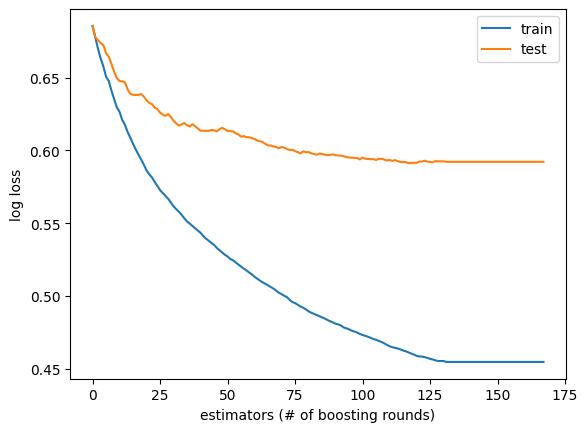

5
Accuracy: 0.685


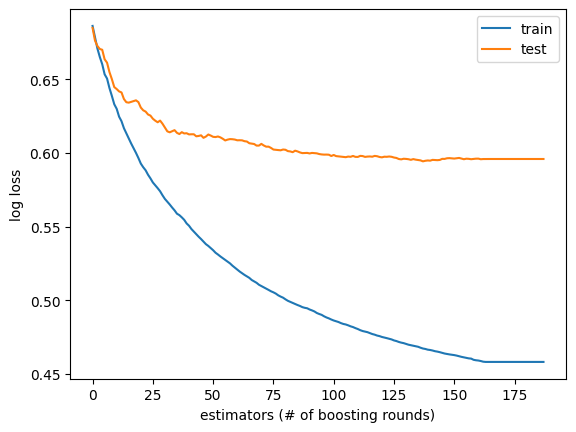

10
Accuracy: 0.697


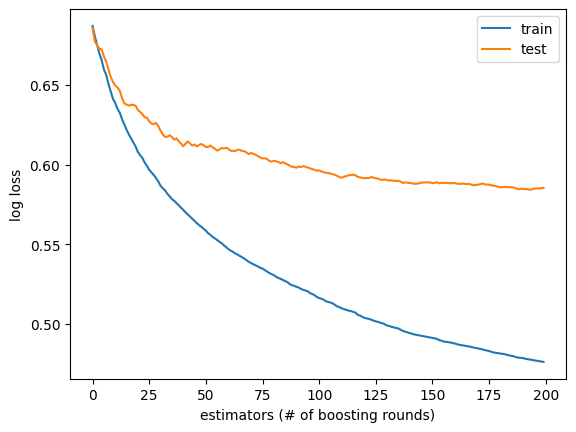

15
Accuracy: 0.674


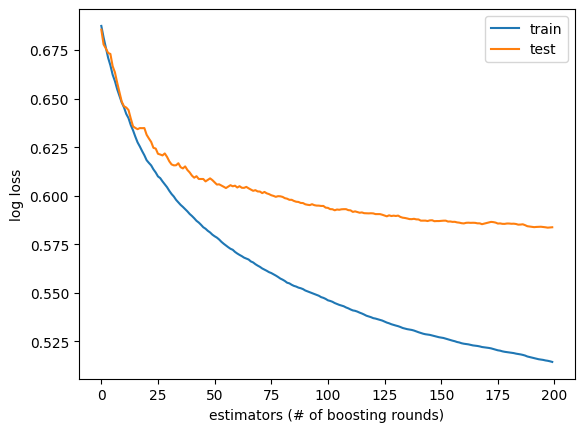

20
Accuracy: 0.697


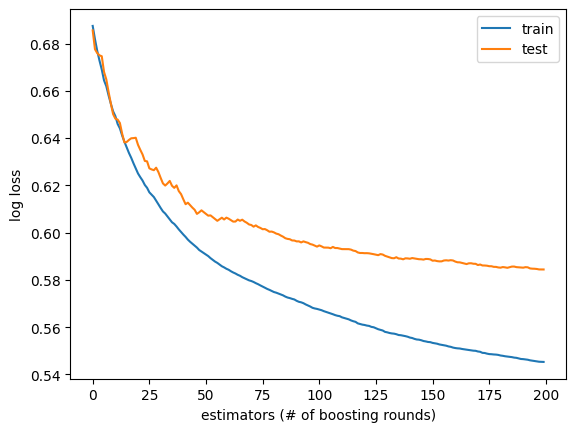

In [8]:
ranges = [1, 5, 10, 15, 20]
parameter = 'min_child_weight'

testhyperparameterranges(train, validation, parameter, ranges)

0.1
Accuracy: 0.674


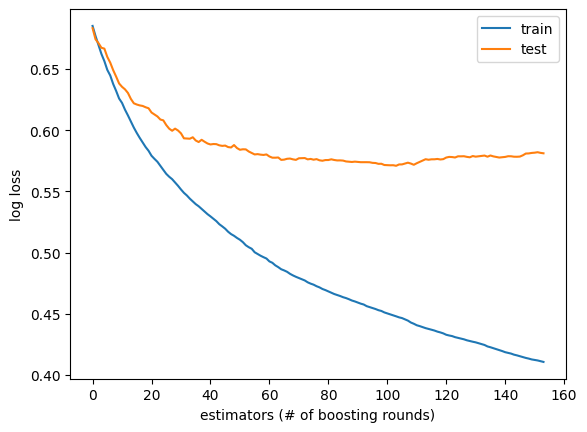

1
Accuracy: 0.697


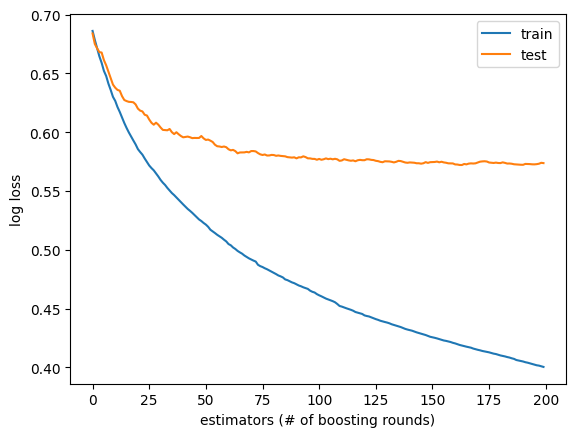

5
Accuracy: 0.697


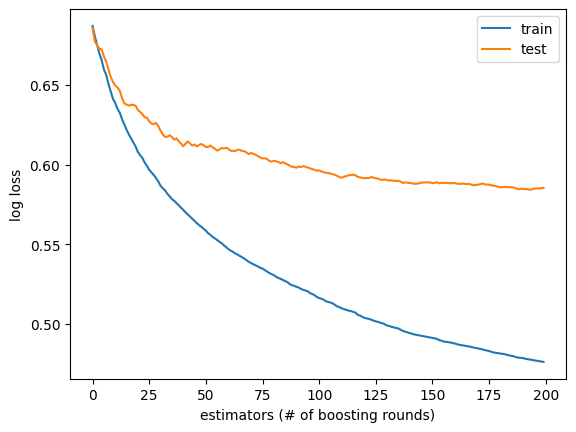

10
Accuracy: 0.708


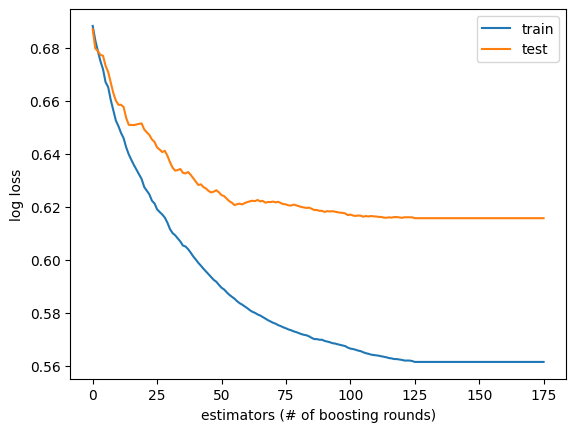

15
Accuracy: 0.685


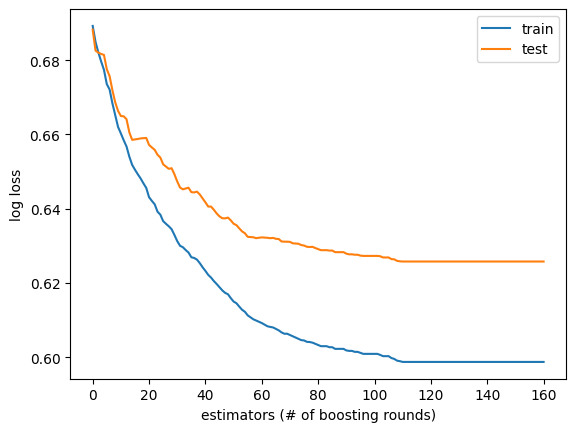

In [9]:
ranges = [0.1, 1, 5, 10, 15]
parameter = 'reg_alpha'

testhyperparameterranges(train, validation, parameter, ranges)

## Actual tuning using hyperopt

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


100%|██████████| 50/50 [01:05<00:00,  1.31s/trial, best loss: -0.7607662835249043]
best hyperparameters {'colsample_bytree': 0.75, 'learning_rate': 0.03743437909668194, 'max_depth': 8.0, 'min_child_weight': 3.0, 'n_estimators': 150.0, 'reg_alpha': 7.0, 'subsample': 0.8917403421234356}
Accuracy: 0.697


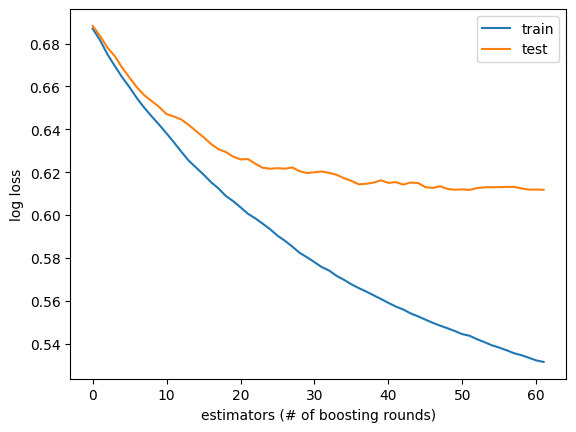

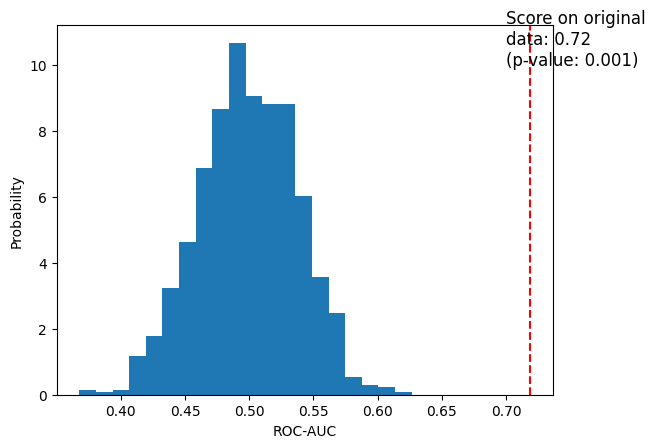

In [10]:
#test
executionid = 1

df_model = pd.read_csv(f'{base_dir}raw_data/reprocessed_model_log.csv')

file_name_base = str(df_model[df_model['ExecutionID'] == executionid][['aggregation_time','gap']].values[0][0]) + '_years_' + str(df_model[df_model['ExecutionID'] == executionid][['aggregation_time','gap']].values[0][1])    

train = pd.read_csv(f"{base_dir}{suffix}{file_name_base}/train.csv", header = None).to_numpy()
validation = pd.read_csv(f"{base_dir}{suffix}{file_name_base}/validation.csv", header = None).to_numpy()

hyperparamtuning(train, validation, file_name_base, base_dir, output_suffix)

In [11]:
! pip list

Package                           Version
--------------------------------- -----------
alembic                           1.8.1
altair                            4.2.0
anyio                             3.6.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
asttokens                         2.0.8
async-generator                   1.10
attrs                             22.1.0
Babel                             2.10.3
backcall                          0.2.0
backports.functools-lru-cache     1.6.4
beautifulsoup4                    4.11.1
bleach                            5.0.1
blinker                           1.4
bokeh                             2.4.3
Bottleneck                        1.3.5
brotlipy                          0.7.0
cached-property                   1.5.2
catboost                          1.1.1
certifi                           2022.9.24
certipy                           0.1.3
cffi                              1.15.1
charset-normalizer       